In [123]:
import numpy as np
import pandas as pd
import os
import re
import time
import scipy as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col

from pymatch.Matcher import Matcher

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])
    matched = non_treated_df.iloc[indices]
    return matched

def create_bins(maj,ind,df1,df2,num_of_bins):
    bin_min, bin_max = np.min(maj), np.max(maj)
    bins = 10**(np.linspace(np.log10(bin_min), np.log10(bin_max), num_of_bins))
    counts, edges = np.histogram(maj, bins, density=True,weights=np.ones(len(df1)) / len(df1))
    centers = (edges[1:] + edges[:-1])/2.
    
    counts=pd.DataFrame(counts,columns=['counts'])
    centres=pd.DataFrame(centers,columns=['centres'])
    df_maj_hist=pd.concat([counts,centres],axis=1)
    df_maj_hist['dum']=0
    
    bin_min, bin_max = np.min(ind), np.max(ind)
    bins = 10**(np.linspace(np.log10(bin_min), np.log10(bin_max), num_of_bins))
    counts, edges = np.histogram(ind, bins, density=True,weights=np.ones(len(df2)) / len(df2))
    centers = (edges[1:] + edges[:-1])/2.
    
    counts=pd.DataFrame(counts,columns=['counts'])
    centres=pd.DataFrame(centers,columns=['centres'])
    df_ind_hist=pd.concat([counts,centres],axis=1)
    df_ind_hist['dum']=1
    
    df_hist= pd.concat([df_maj_hist, df_ind_hist],axis=0)
    df_hist=df_hist.loc[df_hist['counts']!=0]
    df_hist['logcount']=np.log10(df_hist['counts'])
    df_hist['logcentres']=np.log10(df_hist['centres'])
    
    return df_hist

def create_results_table(model1,name):
    coeffs=[]
    ses=[]
    for i in range(0,len(model1.params)):
        p1=round(model1.params[i],3)
        if model1.pvalues[i] <0.01:
            p1=str(p1)+'***'
        elif (model1.pvalues[i] > 0.01) & (model1.pvalues[i] < 0.05):
            p1=str(p1)+'**'
        elif (model1.pvalues[i] > 0.05) & (model1.pvalues[i] < 0.1):
            p1=str(p1)+'*'
        s1=round(model1.bse[i],3)
        s1=('('+str(s1)+')')
        coeffs.append(p1)
        ses.append(s1)
    coeffs.append(model1.nobs)
    coeffs=pd.DataFrame(coeffs)
    ses.append(round(model1.rsquared,3))
    ses=pd.DataFrame(ses)
    coeffs=pd.concat([coeffs,ses],axis=1)
    table=coeffs.stack()
    table=table.reset_index()
    table=table.drop(['level_0','level_1'],axis=1)
    table.columns=[name]
    table.rename(index={0:'c_major_label',1:'s.e.',2:'c_indy_label',3:'s.e.',
                            4:'k_major_label',5:'s.e.',6:'k_indy_label',7:'s.e.',
                            8:'N',9:'R2'}, inplace=True)
    return table

In [124]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
url = urlopen("https://github.com/PeterOrmosi/music_streaming/raw/main/df_m_csv.zip")
zipfile = ZipFile(BytesIO(url.read()))
df_m_raw = pd.read_csv(zipfile.open('df_m_csv.csv'))

url = urlopen("https://github.com/PeterOrmosi/music_streaming/raw/main/df_i_csv.zip")

#Download Zipfile and create pandas DataFrame
zipfile = ZipFile(BytesIO(url.read()))
df_i_raw = pd.read_csv(zipfile.open('df_i_csv.csv'))

C:\Users\peter\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [125]:
# some data cleaning
df_m = df_m_raw.copy()
df_i = df_i_raw.copy()

df_m=df_m[df_m.country=='United Kingdom'] # comment these out if you want to look at all artists
df_i=df_i[df_i.country=='United Kingdom']

df_m = df_m.dropna(subset=['artist'])

df_m.stream1=df_m.stream1.astype(int)
df_m.eas1=df_m.eas1.astype(int)

df_i.stream1=df_i.stream1.astype(int)
df_i.eas1=df_i.eas1.astype(int)

artists_m=np.unique(df_m.artist_o)
artists_i=np.unique(df_i.artist_o)

artist_intersect=list(set(artists_m) & set(artists_i))

df_m=df_m[~(df_m.artist_o.isin(artist_intersect))]
df_i=df_i[~(df_i.artist_o.isin(artist_intersect))]


df_m=df_m[df_m.stream1>0]
df_i=df_i[df_i.stream1>0]

## Figure1

<function matplotlib.pyplot.show(close=None, block=None)>

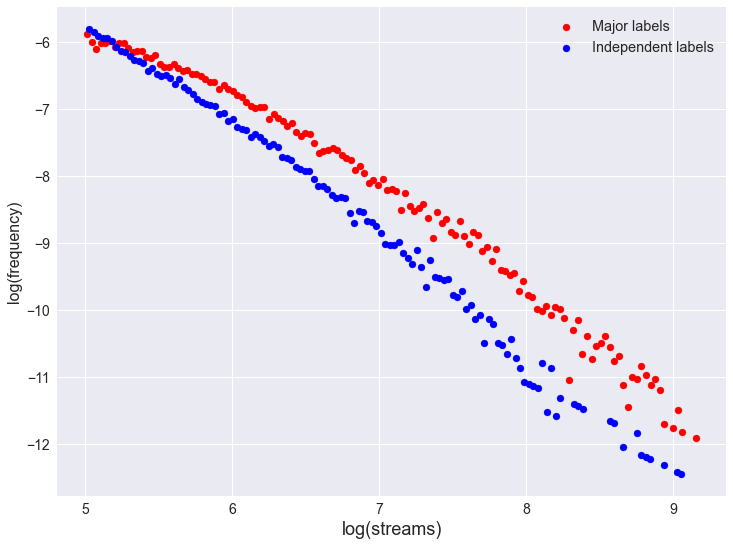

In [129]:
df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj['stream']=df_maj.stream1
df_ind['stream']=df_ind.stream1

df_hist = create_bins(df_maj.stream,df_ind.stream,df_maj,df_ind,200)


df_hist_s=df_hist[(df_hist.logcentres>=5)] # limiting the sample to just the tails where power law is satisfied
model1 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1') # full sample
model1b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1') # only tails


plt.style.use('seaborn')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=(12,9)) 
ax.scatter(df_hist_s.logcentres[df_hist_s.dum==0], df_hist_s.logcount[df_hist_s.dum==0], color= 'red' , marker = 'o',label='Major labels')
ax.scatter(df_hist_s.logcentres[df_hist_s.dum==1], df_hist_s.logcount[df_hist_s.dum==1], color= 'blue' , marker = 'o',label='Independent labels')
plt.legend()
plt.xlabel('log(streams)', fontsize=18)
plt.ylabel('log(frequency)', fontsize=16)
plt.show

In [70]:
# major v indy

df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj['stream']=df_maj.stream1/(np.sum(df_maj.stream1))
df_ind['stream']=df_ind.stream1/(np.sum(df_ind.stream1))

df_hist = create_bins(df_maj.stream,df_ind.stream,df_maj,df_ind,100)


df_hist_s=df_hist[(df_hist.logcentres>=-4)] # limiting the sample to just the tails where power law is satisfied
model1 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1') # full sample
model1b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1') # only tails

tabgb1 = create_results_table(model1,'indy v major')
tgb1=tabgb1[6:8].reset_index().iloc[:,1]
tabgb21 = create_results_table(model1b,'indy v major')
tgb21=tabgb21[6:8].reset_index().iloc[:,1]

In [72]:
# MATCHED SAMPLEs (major v indy)

df_maj=df_m.copy()
df_ind=df_i.copy()

artists_m=df_maj.groupby(['artist'])['stream1','eas1'].mean()
artists_m=pd.DataFrame(artists_m,columns=['stream1','eas1'])
artists_i=df_ind.groupby(['artist'])['stream1','eas1'].mean()
artists_i=pd.DataFrame(artists_i,columns=['stream1','eas1'])

matched_df = get_matching_pairs(artists_i, artists_m)
matched_df=matched_df.reset_index()
artists_match=list(matched_df.artist)
df_maj=df_maj[df_maj.artist.isin(artists_match)]

df_maj['stream']=df_maj.stream1/(np.sum(df_maj.stream1))
df_ind['stream']=df_ind.stream1/(np.sum(df_ind.stream1))

df_hist = create_bins(df_maj.stream,df_ind.stream,df_maj,df_ind,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model2 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model2b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgb2 = create_results_table(model2,'indy v major knn')
tgb2=tabgb2[6:8].reset_index().iloc[:,1]
tabgb22 = create_results_table(model2b,'indy v major knn')
tgb22=tabgb22[6:8].reset_index().iloc[:,1]

tablegb1=pd.concat([tabgb1,tabgb2],axis=1)
tablegb21=pd.concat([tabgb21,tabgb22],axis=1)

C:\Users\peter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\peter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [73]:
### compare within indy

df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj['stream']=df_maj.stream1/(np.sum(df_maj.stream1))
df_ind['stream']=df_ind.stream1/(np.sum(df_ind.stream1))

indy_cat=df_ind.groupby(['label_name'])['stream'].count()
indy_cat=indy_cat.sort_values(ascending=False)

top_ind=indy_cat.index[0:10]
df_ind['top']=np.where(df_ind.label_name.apply(lambda x: any([y in x for y in top_ind])),1,0)

df_ind_top=df_ind[df_ind['top']==1]
df_ind_low=df_ind[df_ind['top']==0]

#list(set(df_ind_top.label_name))

df_hist = create_bins(df_ind_top.stream,df_ind_low.stream,df_ind_top,df_ind_low,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model3 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model3b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgb3 = create_results_table(model3,'indy (top) v indy (low)')
tgb3=tabgb3[6:8].reset_index().iloc[:,1]
tabgb23 = create_results_table(model3b,'indy (top) v indy (low)')
tgb23=tabgb23[6:8].reset_index().iloc[:,1]

In [74]:
## compare within major

df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj['stream']=df_maj.stream1/(np.sum(df_maj.stream1))
df_ind['stream']=df_ind.stream1/(np.sum(df_ind.stream1))

df_maj['top']=np.where(df_maj.label_name=='Sony',1,0)

df_maj_sony=df_maj[df_maj['top']==1]
df_maj_umg=df_maj[df_maj['top']==0]

df_hist = create_bins(df_maj_sony.stream,df_maj_umg.stream,df_maj_sony,df_maj_umg,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model4 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model4b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgb4 = create_results_table(model4,'sony v umg')
tgb4=tabgb4[6:8].reset_index().iloc[:,1]
tabgb24 = create_results_table(model4b,'sony v umg')
tgb24=tabgb24[6:8].reset_index().iloc[:,1]

In [75]:
### compare top indy with major

df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj=df_m[df_m.stream1>0]
df_ind=df_i[df_i.stream1>0]

indy_cat=df_ind.groupby(['artist_o'])['stream1'].sum()
indy_cat=indy_cat.sort_values(ascending=False)

top_ind=indy_cat.index[0:200]
df_ind['top']=np.where(df_ind.artist_o.apply(lambda x: any([y in x for y in top_ind])),1,0)
df_ind=df_ind[df_ind['top']==1]

df_maj['stream']=df_maj.stream1/(np.sum(df_maj.stream1))
df_ind['stream']=df_ind.stream1/(np.sum(df_ind.stream1))

df_hist = create_bins(df_maj.stream,df_ind.stream,df_maj,df_ind,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model5 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model5b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgb5 = create_results_table(model5,'indy (top) v maj')
tgb5=tabgb5[6:8].reset_index().iloc[:,1]
tabgb25 = create_results_table(model5b,'indy (top) v maj')
tgb25=tabgb25[6:8].reset_index().iloc[:,1]

tablegb2=pd.concat([tabgb3,tabgb4,tabgb5],axis=0)
tablegb22=pd.concat([tabgb23,tabgb24,tabgb25],axis=0)
    


### Growth

In [100]:
# data cleaning 

df_m = df_m_raw.copy()
df_i = df_i_raw.copy()

df_m=df_m[df_m.country=='United Kingdom']
df_i=df_i[df_i.country=='United Kingdom']

df_m=df_m[df_m.stream2.notnull()]
df_i=df_i[df_i.stream2.notnull()]

df_m['growth']=df_m.stream2-df_m.stream1
df_i['growth']=df_i.stream2-df_i.stream1

artists_m=np.unique(df_m.artist_o)
artists_i=np.unique(df_i.artist_o)

artist_intersect=list(set(artists_m) & set(artists_i))

df_m=df_m[~(df_m.artist_o.isin(artist_intersect))]
df_i=df_i[~(df_i.artist_o.isin(artist_intersect))]

df_m=df_m[df_m.growth>0]
df_i=df_i[df_i.growth>0]

In [101]:
# major v indy

df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj['growth']=df_maj.growth/(np.sum(df_maj.growth))
df_ind['growth']=df_ind.growth/(np.sum(df_ind.growth))

df_hist = create_bins(df_maj.growth,df_ind.growth,df_maj,df_ind,100)

df_hist_s=df_hist[(df_hist.logcentres>=-4)] # limiting the sample to just the tails where power law is satisfied
model1 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1') # full sample
model1b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1') # only tails

tabgbg1 = create_results_table(model1,'indy v major')
tgbg1=tabgbg1[6:8].reset_index().iloc[:,1]
tabgbg21 = create_results_table(model1b,'indy v major')
tgbg21=tabgb21[6:8].reset_index().iloc[:,1]


In [102]:
# MATCHED SAMPLEs (major v indy)

df_maj=df_m.copy()
df_ind=df_i.copy()

artists_m=df_maj.groupby(['artist'])['growth'].mean()
artists_m=pd.DataFrame(artists_m,columns=['growth'])
artists_i=df_ind.groupby(['artist'])['growth'].mean()
artists_i=pd.DataFrame(artists_i,columns=['growth'])

matched_df = get_matching_pairs(artists_i, artists_m)
matched_df=matched_df.reset_index()
artists_match=list(matched_df.artist)
df_maj=df_maj[df_maj.artist.isin(artists_match)]

df_maj['growth']=df_maj.growth/(np.sum(df_maj.growth))
df_ind['growth']=df_ind.growth/(np.sum(df_ind.growth))

df_hist = create_bins(df_maj.growth,df_ind.growth,df_maj,df_ind,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model2 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model2b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgbg2 = create_results_table(model2,'indy v major knn')
tgbg2=tabgbg2[6:8].reset_index().iloc[:,1]
tabgbg22 = create_results_table(model2b,'indy v major knn')
tgbg22=tabgbg22[6:8].reset_index().iloc[:,1]

tablegbg1=pd.concat([tabgbg1,tabgbg2],axis=1)
tablegbg21=pd.concat([tabgbg21,tabgbg22],axis=1)

In [103]:
### compare within indy

df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj['growth']=df_maj.growth/(np.sum(df_maj.growth))
df_ind['growth']=df_ind.growth/(np.sum(df_ind.growth))

indy_cat=df_ind.groupby(['label_name'])['growth'].count()
indy_cat=indy_cat.sort_values(ascending=False)

top_ind=indy_cat.index[0:10]
df_ind['top']=np.where(df_ind.label_name.apply(lambda x: any([y in x for y in top_ind])),1,0)

df_ind_top=df_ind[df_ind['top']==1]
df_ind_low=df_ind[df_ind['top']==0]

#list(set(df_ind_top.label_name))

df_hist = create_bins(df_ind_top.growth,df_ind_low.growth,df_ind_top,df_ind_low,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model3 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model3b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgbg3 = create_results_table(model3,'indy (top) v indy (low)')
tgbg3=tabgbg3[6:8].reset_index().iloc[:,1]
tabgbg23 = create_results_table(model3b,'indy (top) v indy (low)')
tgbg23=tabgbg23[6:8].reset_index().iloc[:,1]

In [104]:
## compare within major

df_maj=df_m.copy()
df_ind=df_i.copy()

df_maj['growth']=df_maj.growth/(np.sum(df_maj.growth))
df_ind['growth']=df_ind.growth/(np.sum(df_ind.growth))

df_maj['top']=np.where(df_maj.label_name=='Sony',1,0)

df_maj_sony=df_maj[df_maj['top']==1]
df_maj_umg=df_maj[df_maj['top']==0]

df_hist = create_bins(df_maj_sony.growth,df_maj_umg.growth,df_maj_sony,df_maj_umg,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model4 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model4b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgbg4 = create_results_table(model4,'sony v umg')
tgbg4=tabgbg4[6:8].reset_index().iloc[:,1]
tabgbg24 = create_results_table(model4b,'sony v umg')
tgbg24=tabgbg24[6:8].reset_index().iloc[:,1]

In [105]:
### compare top indy with major

df_maj=df_m.copy()
df_ind=df_i.copy()


indy_cat=df_ind.groupby(['artist_o'])['growth'].sum()
indy_cat=indy_cat.sort_values(ascending=False)

top_ind=indy_cat.index[0:200]
df_ind['top']=np.where(df_ind.artist_o.apply(lambda x: any([y in x for y in top_ind])),1,0)
df_ind=df_ind[df_ind['top']==1]

df_maj['growth']=df_maj.growth/(np.sum(df_maj.growth))
df_ind['growth']=df_ind.growth/(np.sum(df_ind.growth))

df_hist = create_bins(df_maj.growth,df_ind.growth,df_maj,df_ind,100)

df_hist_s=df_hist[df_hist.logcentres>=-4] # you can try to eliminate the curvy bit
model5 = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist).fit(cov_type='HC1')
model5b = sm.ols(formula = 'logcount ~ dum + logcentres + (dum*logcentres)', data = df_hist_s).fit(cov_type='HC1')

tabgbg5 = create_results_table(model5,'indy (top) v maj')
tgbg5=tabgbg5[6:8].reset_index().iloc[:,1]
tabgbg25 = create_results_table(model5b,'indy (top) v maj')
tgbg25=tabgbg25[6:8].reset_index().iloc[:,1]

tablegbg2=pd.concat([tabgbg3,tabgbg4,tabgbg5],axis=0)
tablegbg22=pd.concat([tabgbg23,tabgbg24,tabgbg25],axis=0)
    


## Replicating Table 2

In [106]:
t_first= [tgb1, tgb2, tgb21, tgb22]
tg_first = [tgbg1, tgbg2, tgbg21, tgbg22]

main = pd.concat(t_first, axis=1, keys=[s.name for s in t_first])
maing = pd.concat(tg_first, axis=1, keys=[s.name for s in tg_first])

main=pd.concat([main,maing],axis=0)

main.columns = ['Full sample','','Tails with power law','']
main.columns=[main.columns,['major v indy', 'major v indy (matched)','major v indy', 'major v indy (matched)']]

main

,Full sample,,Tails with power law,
,major v indy,major v indy (matched),major v indy,major v indy (matched)
0,-0.411***,-0.351***,-0.175**,-0.273***
1,(0.053),(0.057),(0.068),(0.055)
0,-0.256***,-0.372***,-0.175**,-0.243***
1,(0.052),(0.053),(0.068),(0.065)


## Replicating Table 3

In [108]:
t_counterfact=[tgb3, tgb4, tgb5, tgb23, tgb24, tgb25]
tg_counterfact=[tgbg3, tgbg4, tgbg5, tgbg23, tgbg24, tgbg25]

main2 = pd.concat(t_counterfact, axis=1, keys=[s.name for s in t_counterfact])
main2g = pd.concat(tg_counterfact, axis=1, keys=[s.name for s in tg_counterfact])

main2=pd.concat([main2,main2g],axis=0)

main2.columns = ['','Full sample','','','Tails with power law','']

main2.columns=[main2.columns,['indy (top) v indy (other)', 'sony v umg','indy (top) v major','indy (top) v indy (other)', 'sony v umg','indy (top) v major']]

main2

Full sample                     \
  indy (top) v indy (other)  sony v umg indy (top) v major   
0                     0.035      -0.028          -0.366***   
1                   (0.047)     (0.059)            (0.055)   
0                    -0.002      -0.042          -0.208***   
1                   (0.047)     (0.057)            (0.055)   

                            Tails with power law                     
  indy (top) v indy (other)           sony v umg indy (top) v major  
0                     0.135                0.017           -0.175**  
1                   (0.089)              (0.071)            (0.068)  
0                    -0.075                0.087          -0.246***  
1                   (0.057)               (0.09)            (0.067)

## Replicating Table A4

In [109]:
table_first= [tablegb1, tablegb21]
tableg_first = [tablegbg1, tablegbg21]

main = pd.concat(table_first, axis=1, keys=[s.name for s in t_first])
maing = pd.concat(tableg_first, axis=1, keys=[s.name for s in tg_first])

main=pd.concat([main,maing],axis=0)

main.columns = ['Full sample','','Tails with power law','']
main.columns=[main.columns,['major v indy', 'major v indy (matched)','major v indy', 'major v indy (matched)']]

main

,Full sample,,Tails with power law,
,major v indy,major v indy (matched),major v indy,major v indy (matched)
c_major_label,-1.738***,-1.976***,-4.141***,-3.69***
s.e.,(0.207),(0.201),(0.162),(0.106)
c_indy_label,-2.076***,-1.837***,-1.234***,-1.684***
s.e.,(0.258),(0.253),(0.22),(0.182)
k_major_label,-1.065***,-1.124***,-1.81***,-1.712***
s.e.,(0.041),(0.047),(0.052),(0.032)
k_indy_label,-0.411***,-0.351***,-0.175**,-0.273***
s.e.,(0.053),(0.057),(0.068),(0.055)
N,196.0,191.0,74.0,80.0


## Replicating Table A5

In [119]:
table_counterfact= [tablegb2, tablegb22]
tableg_counterfact = [tablegbg2, tablegbg22]

main2 = pd.concat(table_counterfact, axis=1) #, keys=[s.name for s in t_first])
main2g = pd.concat(tableg_counterfact, axis=1) #, keys=[s.name for s in tg_first])

main2=pd.concat([main2,main2g],axis=0)

main2.columns = ['','Full sample','','','Tails with power law','']

main2.columns=[main2.columns,['indy (top) v indy (other)', 'sony v umg','indy (top) v major','indy (top) v indy (other)', 'sony v umg','indy (top) v major']]

main2

AttributeError: 'NoneType' object has no attribute 'reset_index'